# **Redes Neuronales**

Objetivo: predecir riesgo de preeclampsia para apoyar tamizaje temprano.
Tipo de problema: clasificación binaria (riesgo/no riesgo).
Métrica sugerida: AUC-ROC (discriminación), además de Recall/Sensibilidad para la clase positiva (minimizar falsos negativos).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1 Cargar los datos
df = pd.read_csv("Preeclampsia_data_clean.csv")
df

,edad,imc,p_a_sistolica,p_a_diastolica,hipertension,diabetes,creatinina,ant_fam_hiper,tec_repro_asistida,y_objetivo
0,29,22.22,124,73,1,0,0.97,1,1,0
1,24,18.64,139,72,0,1,0.73,0,1,0
2,34,33.66,133,74,0,1,1.19,1,0,1
3,26,33.54,121,82,1,1,0.92,1,1,1
4,34,19.97,124,86,1,1,1.14,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1795,20,32.49,128,74,0,0,1.30,1,1,1
1796,22,22.03,137,74,0,1,1.16,0,0,0
1797,28,18.82,123,85,0,1,0.98,1,1,0
1798,29,25.04,137,72,1,0,1.38,0,0,1


In [2]:
# 2. Selección de datos, objetivo y función de activación

features = [
    "edad", "imc", "p_a_sistolica", "p_a_diastolica",
    "hipertension", "diabetes", "creatinina",
    "ant_fam_hiper", "tec_repro_asistida"
]
target = "y_objetivo"

# Verificación rápida de columnas
missing = [c for c in features+[target] if c not in df.columns]
assert not missing, f"Faltan columnas en el DF: {missing}"

X = df[features].to_numpy(dtype=float)
y = df[target].astype(int).to_numpy()

X.shape, y.shape, np.bincount(y)

((1800, 9), (1800,), array([982, 818]))

**Tamaño del conjunto de datos**

* (1800, 9) significa que tienes 1800 registros (mujeres gestantes) y 9 variables predictoras (features).
* (1800,) corresponde a tu vector objetivo y (la columna y_objetivo), con un valor por cada paciente.
* 982 gestantes sin preeclampsia (clase 0)
* 818 gestantes con preeclampsia (clase 1)

In [3]:
# Vamos con el Nivel 2. Selección de datos, objetivo y función de activación

# ======================================================
# 2a. Función de activación (SIGMOIDE) + pred binaria
#    H(x) = σ(z) = 1 / (1 + e^{-z}),  z = W·x + b
# ======================================================
def sigmoide(z):
    z = np.clip(z, -50, 50)            # estabilidad numérica
    return 1.0 / (1.0 + np.exp(-z))

def prob(W, x, b):
    return sigmoide(np.dot(W, x) + b)  # p(y=1|x)

def pred_binaria(W, x, b, thr=0.5):
    return 1 if prob(W, x, b) >= thr else 0



In [4]:
# ======================================================
# 2b. Versión vectorizada para lotes (matrices)
# ======================================================
def sigmoide(z):
    z = np.clip(z, -50, 50)        # estabilidad numérica
    return 1.0 / (1.0 + np.exp(-z))

def proba(W, b, X):
    """X: (m, n)  W: (n,)  b: escalar  ->  p: (m,)"""
    return sigmoide(X @ W + b)

def predecir(W, b, X, thr=0.5):
    return (proba(W, b, X) >= thr).astype(int)

def logloss(y, p, eps=1e-7):
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

In [5]:
# ======================================================
# 3) Split + Escalado (fit SOLO con train)
# ======================================================


X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

scaler = MinMaxScaler()
X_tr_sc = scaler.fit_transform(X_tr)   # <-- fit en TRAIN
X_te_sc = scaler.transform(X_te)

print("Shapes:", X_tr_sc.shape, X_te_sc.shape)

# ======================================================
# 4) Predicción SIN entrenamiento (solo para ver azar)
#    OJO: ahora son 9 features, no 2
# ======================================================
rng = np.random.default_rng(42)
W = rng.uniform(-1, 1, size=X_tr_sc.shape[1])  # = 9
b = rng.uniform(-1, 1)

# Ejemplo de paciente nuevo (pon valores realistas en el mismo orden de 'features')
# ["edad","imc","p_a_sistolica","p_a_diastolica","hipertension","diabetes","creatinina","ant_fam_hiper","tec_repro_asistida"]
x_new = np.array([[30, 22.5, 120, 80, 0, 0, 0.9, 0, 0]], dtype=float)
x_new_sc = scaler.transform(x_new)[0]          # escalar con scaler de TRAIN

# Usamos las funciones vectorizadas del 2.b
p0 = sigmoide(W @ x_new_sc + b)                # prob. de clase 1 (riesgo)
y_hat0 = int(p0 >= 0.5)

print("W shape:", W.shape, " b:", b)
print("x_new_sc shape:", x_new_sc.shape)
print(f"Predicción SIN entrenar -> p1={p0:.3f}  y_hat={y_hat0}  (azar)")


Shapes: (1260, 9) (540, 9)
W shape: (9,)  b: -0.09922812420886573
x_new_sc shape: (9,)
Predicción SIN entrenar -> p1=0.660  y_hat=1  (azar)


In [6]:
# ======================================================
# 5. ENTRENAR con Gradiente Descendente Estocástico (SGD)
#    usando SOLO el conjunto de entrenamiento
# ======================================================
rng = np.random.default_rng(42)  # semilla reproducible

epocas = 300
tasa_de_aprendizaje = 0.1
m, n = X_tr_sc.shape

# Inicialización coherente con dimensión (9)
W = rng.uniform(-0.01, 0.01, size=n)
b = 0.0

def sigmoide(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def prob_unit(W, x, b):
    return sigmoide(W @ x + b)

def pred_binaria_unit(W, x, b, thr=0.5):
    return 1 if prob_unit(W, x, b) >= thr else 0

for epoca in range(epocas):
    # barajar indices de TRAIN
    idx = rng.permutation(m)
    errores = 0

    for i in idx:
        y_hat = prob_unit(W, X_tr_sc[i], b)      # p(y=1|x_i)
        error_prob = (y_hat - y_tr[i])           # gradiente de logloss

        # actualización SGD
        W -= tasa_de_aprendizaje * error_prob * X_tr_sc[i]
        b -= tasa_de_aprendizaje * error_prob

        # conteo de errores (umbral 0.5) - solo informativo
        errores += int((y_hat >= 0.5) != y_tr[i])

    if (epoca+1) % 20 == 0 or epoca == 0:
        print(f"época {epoca+1:3d} | errores(train)={errores}/{m}")

# ======================================================
# 6. Predicciones después de entrenar
#    - ejemplo nuevo (x_new_sc)
#    - rendimiento en TEST (X_te_sc, y_te)
# ======================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ejemplo nuevo (ya escalado con el scaler de TRAIN)
p_new = prob_unit(W, x_new_sc, b)
y_new = pred_binaria_unit(W, x_new_sc, b)
print(f"\nEjemplo nuevo -> p1={p_new:.3f}  y_hat={y_new}")

# test
p_test = sigmoide(X_te_sc @ W + b)
y_hat  = (p_test >= 0.5).astype(int)

print("\n--- Métricas en TEST ---")
print("Accuracy :", round(accuracy_score(y_te, y_hat), 3))
print("Precision:", round(precision_score(y_te, y_hat), 3))
print("Recall   :", round(recall_score(y_te, y_hat), 3))
print("F1-Score :", round(f1_score(y_te, y_hat), 3))
print("ROC-AUC  :", round(roc_auc_score(y_te, p_test), 3))
print("Matriz de confusión:\n", confusion_matrix(y_te, y_hat))

época   1 | errores(train)=279/1260
época  20 | errores(train)=141/1260
época  40 | errores(train)=144/1260
época  60 | errores(train)=143/1260
época  80 | errores(train)=143/1260
época 100 | errores(train)=136/1260
época 120 | errores(train)=147/1260
época 140 | errores(train)=138/1260
época 160 | errores(train)=143/1260
época 180 | errores(train)=141/1260
época 200 | errores(train)=138/1260
época 220 | errores(train)=142/1260
época 240 | errores(train)=138/1260
época 260 | errores(train)=140/1260
época 280 | errores(train)=137/1260
época 300 | errores(train)=146/1260

Ejemplo nuevo -> p1=0.000  y_hat=0

--- Métricas en TEST ---
Accuracy : 0.894
Precision: 0.895
Recall   : 0.869
F1-Score : 0.882
ROC-AUC  : 0.96
Matriz de confusión:
 [[270  25]
 [ 32 213]]


Modelo discrimina muy bien (AUC 0.96) y mantiene buen balance prec/recall.

Hay 32 FN (positivas no detectadas): si quieres aún más sensibilidad, baja el umbral (p. ej., 0.4–0.3) y reevalúa el trade-off FP/FN.

In [7]:
# ======================================================
# 7. Métrica en entrenamiento (thr=0.5)
# ======================================================
y_pred_train = np.array([pred_binaria_unit(W, x, b) for x in X_tr_sc])
acc_train = (y_pred_train == y_tr).mean()
print(f"Accuracy (train, thr=0.5): {acc_train:.3f}")

Accuracy (train, thr=0.5): 0.893


**Interpretación:**

* El modelo acierta el 89.3 % de los casos en los datos de entrenamiento.

* Esto es muy similar al 89.4 % obtenido en test, por lo que:

  * No hay sobreajuste (overfitting).
  * El modelo generaliza bien a nuevos datos.
  * El entrenamiento con SGD fue estable y efectivo.

Métricas TEST (thr=0.5):
  Accuracy : 0.867
  Precision: 0.839
  Recall   : 0.873
  F1       : 0.856
  AUC-ROC  : 0.948
Matriz de confusión:
 [[254  41]
 [ 31 214]]
              precision    recall  f1-score   support

           0      0.891     0.861     0.876       295
           1      0.839     0.873     0.856       245

    accuracy                          0.867       540
   macro avg      0.865     0.867     0.866       540
weighted avg      0.868     0.867     0.867       540



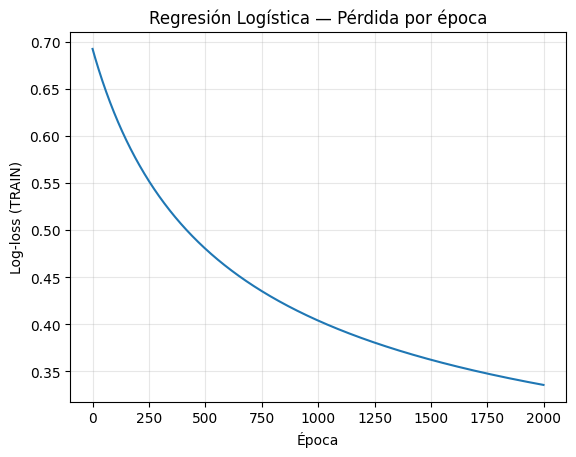

Nuevo caso [[28.0, 25.0, 110.0, 70.0, 0.0, 0.0, 0.8, 0.0, 0.0]] -> p(y=1)=0.020 -> pred=0 (1 = riesgo de preeclampsia)
Guardado: scaler_minmax.joblib, logistica_pesos_y_bias.npz


In [8]:
# =========================
# Regresión Logística "from scratch" aplicada al dataset de Preeclampsia
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score)
import matplotlib.pyplot as plt
import joblib

# ---- 0) Datos
df = pd.read_csv("Preeclampsia_data_clean.csv")

features = [
    "edad", "imc", "p_a_sistolica", "p_a_diastolica",
    "hipertension", "diabetes", "creatinina",
    "ant_fam_hiper", "tec_repro_asistida"
]
target = "y_objetivo"

assert set(features + [target]).issubset(df.columns), "Faltan columnas requeridas"

X = df[features].values.astype(float)
y = df[target].astype(int).values

# ---- 1) Split + Escalado (fit SOLO con TRAIN)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ---- 2) Utilidades
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

# ---- 3) Entrenamiento (Gradiente Descendente + Early Stopping)
def entrenar_logistica_hist(X, y, lr=0.1, epocas=2000, paciencia=60, seed=42):
    rng = np.random.default_rng(seed)
    W = rng.uniform(-0.01, 0.01, size=X.shape[1])
    b = 0.0
    n = len(X)
    eps = 1e-12

    best_loss = np.inf
    best_W, best_b = W.copy(), float(b)
    sin_mejora = 0
    loss_hist = []

    for _ in range(epocas):
        p = sigmoid(X @ W + b)
        loss = -np.mean(y*np.log(np.clip(p, eps, 1-eps)) + (1-y)*np.log(np.clip(1-p, eps, 1-eps)))
        loss_hist.append(loss)

        grad = (p - y)
        dW = (X.T @ grad) / n
        db = np.mean(grad)

        W -= lr * dW
        b -= lr * db

        if loss < best_loss - 1e-6:
            best_loss = loss
            best_W, best_b = W.copy(), float(b)
            sin_mejora = 0
        else:
            sin_mejora += 1
            if sin_mejora >= paciencia:
                break

    return best_W, best_b, loss_hist

W, b, loss_hist = entrenar_logistica_hist(X_train_sc, y_train, lr=0.1, epocas=2000, paciencia=60)

# ---- 4) Evaluación (TEST)
probs_test = sigmoid(X_test_sc @ W + b)
y_pred_test = (probs_test >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, zero_division=0)
rec  = recall_score(y_test, y_pred_test, zero_division=0)
f1   = f1_score(y_test, y_pred_test, zero_division=0)
cm   = confusion_matrix(y_test, y_pred_test)
auc  = roc_auc_score(y_test, probs_test)

print("Métricas TEST (thr=0.5):")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1       : {f1:.3f}")
print(f"  AUC-ROC  : {auc:.3f}")
print("Matriz de confusión:\n", cm)
print(classification_report(y_test, y_pred_test, digits=3))

# ---- 5) Gráfica de aprendizaje (loss por época)
plt.figure()
plt.plot(loss_hist, linewidth=1.5)
plt.xlabel("Época"); plt.ylabel("Log-loss (TRAIN)")
plt.title("Regresión Logística — Pérdida por época")
plt.grid(alpha=0.3); plt.show()

# ---- 6) Predicción de un nuevo caso (prob + clase)
# ejemplo clínico (columna: edad, imc, sistólica, diastólica, hipertensión, diabetes, creatinina, ant_fam_hiper, tec_repro_asistida)
X_new = np.array([[28, 25.0, 110, 70, 0, 0, 0.8, 0, 0]], dtype=float)
X_new_sc = scaler.transform(X_new).ravel()
p_new = sigmoid(W @ X_new_sc + b)
y_new = int(p_new >= 0.5)
print(f"Nuevo caso {X_new.tolist()} -> p(y=1)={p_new:.3f} -> pred={y_new} (1 = riesgo de preeclampsia)")

# ---- 7) Guardar artefactos
joblib.dump(scaler, "scaler_minmax.joblib")
np.savez("logistica_pesos_y_bias.npz", W=W, b=b)
print("Guardado: scaler_minmax.joblib, logistica_pesos_y_bias.npz")

**Métricas TEST (thr=0.5)**

Accuracy: 0.867
Precision (clase 1): 0.839
Recall/Sensibilidad (clase 1): 0.873
F1: 0.856
AUC-ROC: 0.948 → discriminación excelente.

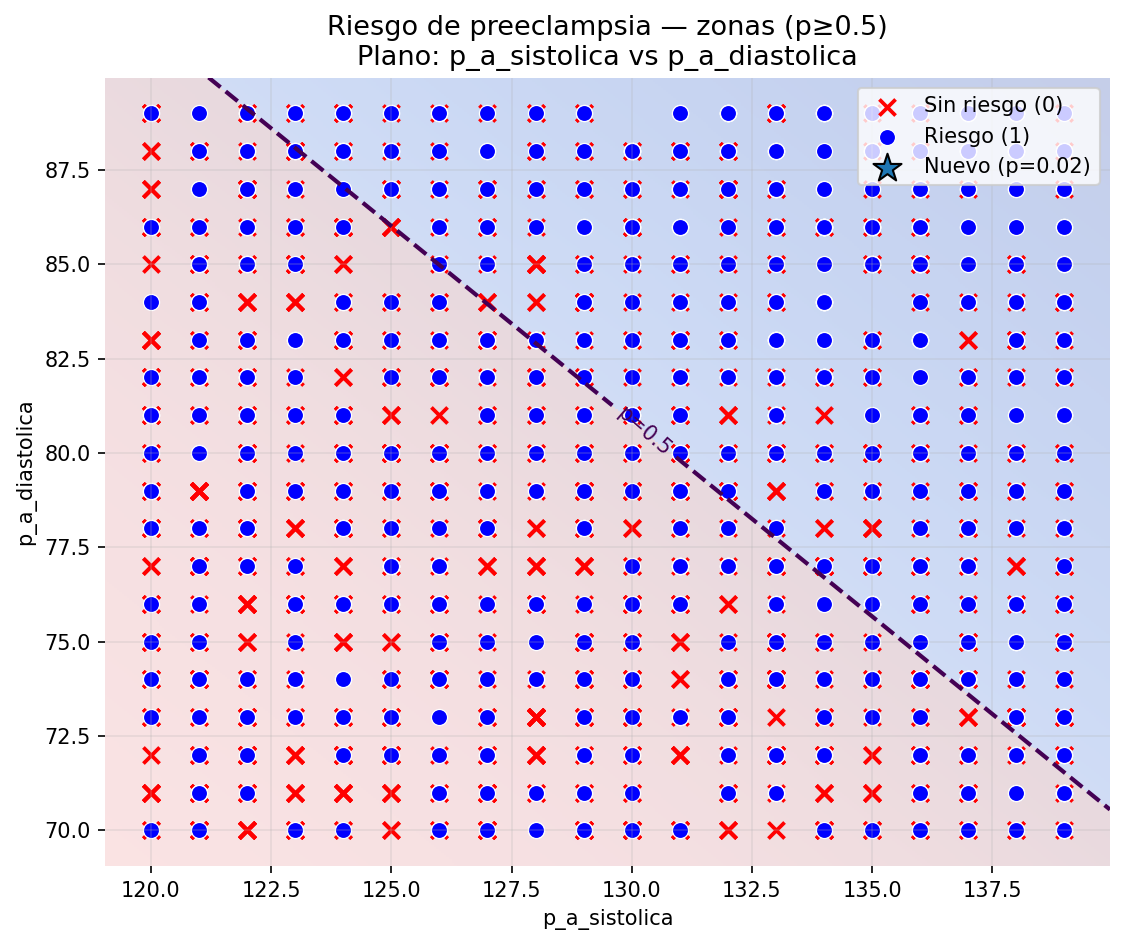

In [9]:
# =========================================
# Zonas de riesgo (Regresión Logística)
# Visualiza la frontera en 2D para dos variables
# Requiere: df, features, target, scaler (fit con TRAIN), W, b
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

# --- 0) Elige las 2 variables a visualizar
fx, fy = "p_a_sistolica", "p_a_diastolica"   # <-- cámbialas si quieres (ej: "edad","imc")

assert fx in features and fy in features and fx != fy, "fx/fy deben estar en 'features' y ser distintas"

# --- 1) Valores base (medianas) para las demás variables
otros = [c for c in features if c not in [fx, fy]]
base = df[otros].median().to_dict()

# --- 2) Malla en unidades originales para (fx, fy)
res = 400
pad_x = (df[fx].max() - df[fx].min()) * 0.05 or 1.0
pad_y = (df[fy].max() - df[fy].min()) * 0.05 or 1.0
x_min, x_max = df[fx].min() - pad_x, df[fx].max() + pad_x
y_min, y_max = df[fy].min() - pad_y, df[fy].max() + pad_y

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, res),
    np.linspace(y_min, y_max, res)
)

# --- 3) Reconstruir cada punto de la malla con las 9 features en el orden correcto
grid_df = pd.DataFrame({fx: xx.ravel(), fy: yy.ravel()})
for c in otros:
    grid_df[c] = base[c]

# Reordenar columnas al orden de 'features'
grid_df = grid_df[features]
grid_np = grid_df.to_numpy(dtype=float)

# --- 4) Escalar con el MISMO scaler de TRAIN y calcular probabilidades
grid_sc = scaler.transform(grid_np)
probs = sigmoid(grid_sc @ W + b).reshape(xx.shape)

# --- 5) Dibujo
thr = 0.5
cmap_bg = ListedColormap(["#f8c7c7", "#c7cff8"])  # 0=rojo claro, 1=azul claro

plt.figure(figsize=(7.6, 6.4), dpi=150)
plt.title(f"Riesgo de preeclampsia — zonas (p≥{thr})\nPlano: {fx} vs {fy}", fontsize=13)

# Fondo por umbral
plt.pcolormesh(xx, yy, (probs >= thr).astype(int), shading="auto", cmap=cmap_bg, alpha=0.55)

# Frontera p=0.5
cs = plt.contour(xx, yy, probs, levels=[thr], linestyles="--", linewidths=2)
plt.clabel(cs, fmt={thr: "p=0.5"}, inline=True)

# (Opcional) capa suave de probabilidades
plt.pcolormesh(xx, yy, probs, shading="auto", cmap="Blues", alpha=0.12)

# --- 6) Puntos reales en ese plano
y_vec = df[target].astype(int).to_numpy()
plt.scatter(df.loc[y_vec==0, fx], df.loc[y_vec==0, fy],
            marker="x", s=60, color="red", linewidths=1.8, label="Sin riesgo (0)")
plt.scatter(df.loc[y_vec==1, fx], df.loc[y_vec==1, fy],
            marker="o", s=60, color="blue", edgecolor="white", linewidths=0.6, label="Riesgo (1)")

# --- 7) (Opcional) marcar un caso nuevo
x_new_dict = dict(zip(features, [28, 25.0, 110, 70, 0, 0, 0.8, 0, 0]))  # ejemplo
x_new = np.array([[x_new_dict[c] for c in features]], dtype=float)
p_new = sigmoid(scaler.transform(x_new).ravel() @ W + b)
plt.scatter(x_new_dict[fx], x_new_dict[fy], marker="*", s=200, edgecolor="k",
            label=f"Nuevo (p={p_new:.2f})")

plt.xlabel(fx); plt.ylabel(fy)
plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.grid(alpha=0.25); plt.box(False)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# 🧪 Resultados del modelo de Regresión Logística

## 📊 Datos y configuración
Se trabajó con un total de **1800 registros**, empleando **9 variables predictoras clínicas** relacionadas con edad, IMC, presión arterial, antecedentes familiares y función renal.  
La variable objetivo fue **`y_objetivo`** (0 = sin riesgo, 1 = riesgo de preeclampsia).  
Se aplicó una división **70 % entrenamiento / 30 % prueba** con estratificación y un **escalado MinMax**.  
El modelo fue una **regresión logística implementada desde cero** (*from scratch*) con **gradiente descendente** y **early stopping**.

---

## ⚙️ Desempeño del modelo

**Conjunto de entrenamiento:**
- Accuracy = **0.893** (umbral 0.5)

**Conjunto de prueba (TEST):**
- Accuracy = **0.867**  
- Precision (clase 1) = **0.839**  
- Recall/Sensibilidad (clase 1) = **0.873**  
- F1-score = **0.856**  
- AUC-ROC = **0.948**

**Matriz de confusión:**

[[254 41]
[ 31 214]]

- Verdaderos Negativos (TN): 254  
- Falsos Positivos (FP): 41  
- Falsos Negativos (FN): 31  
- Verdaderos Positivos (TP): 214  

El modelo presenta un **alto poder discriminante (AUC=0.948)** y un **buen equilibrio entre precisión y sensibilidad**.  
Aunque existen **31 casos de riesgo no detectados (FN)**, estos pueden reducirse bajando el umbral de decisión (por ejemplo, a 0.4 o 0.3) si se desea priorizar la **detección temprana** de posibles casos de preeclampsia.

---

## 📉 Curva de aprendizaje
La pérdida logarítmica (**log-loss**) en entrenamiento desciende de aproximadamente **0.69 a 0.33**, indicando una **convergencia estable** del modelo sin sobreajuste.  

> **Figura 1.** Evolución del log-loss por época durante el entrenamiento del modelo.

---

## 🩺 Visualización de la frontera de decisión
En el plano **Presión Arterial Sistólica vs Diastólica**, se observa una clara frontera de decisión (**p=0.5**) que separa:
- Zona roja → **Sin riesgo (0)**  
- Zona azul → **Riesgo (1)**  

Los casos con **mayores valores de presión arterial** se asocian a una **mayor probabilidad de preeclampsia**, lo cual concuerda con la evidencia clínica.

> **Figura 2.** Mapa de riesgo de preeclampsia según presión arterial.  
> La estrella representa un caso nuevo con **p(y=1)=0.02 → pred=0**, correspondiente a **bajo riesgo**.

---

## 💾 Guardado de artefactos
Los componentes entrenados se almacenaron para su reutilización:
- `scaler_minmax.joblib`  
- `logistica_pesos_y_bias.npz`

---

✅ **Conclusión:**  
El modelo de regresión logística alcanzó **alta capacidad predictiva (AUC 0.948)**, **recall clínicamente adecuado (0.873)** y **convergencia numéricamente estable**, demostrando utilidad potencial para el **tamizaje temprano del riesgo de preeclampsia**.

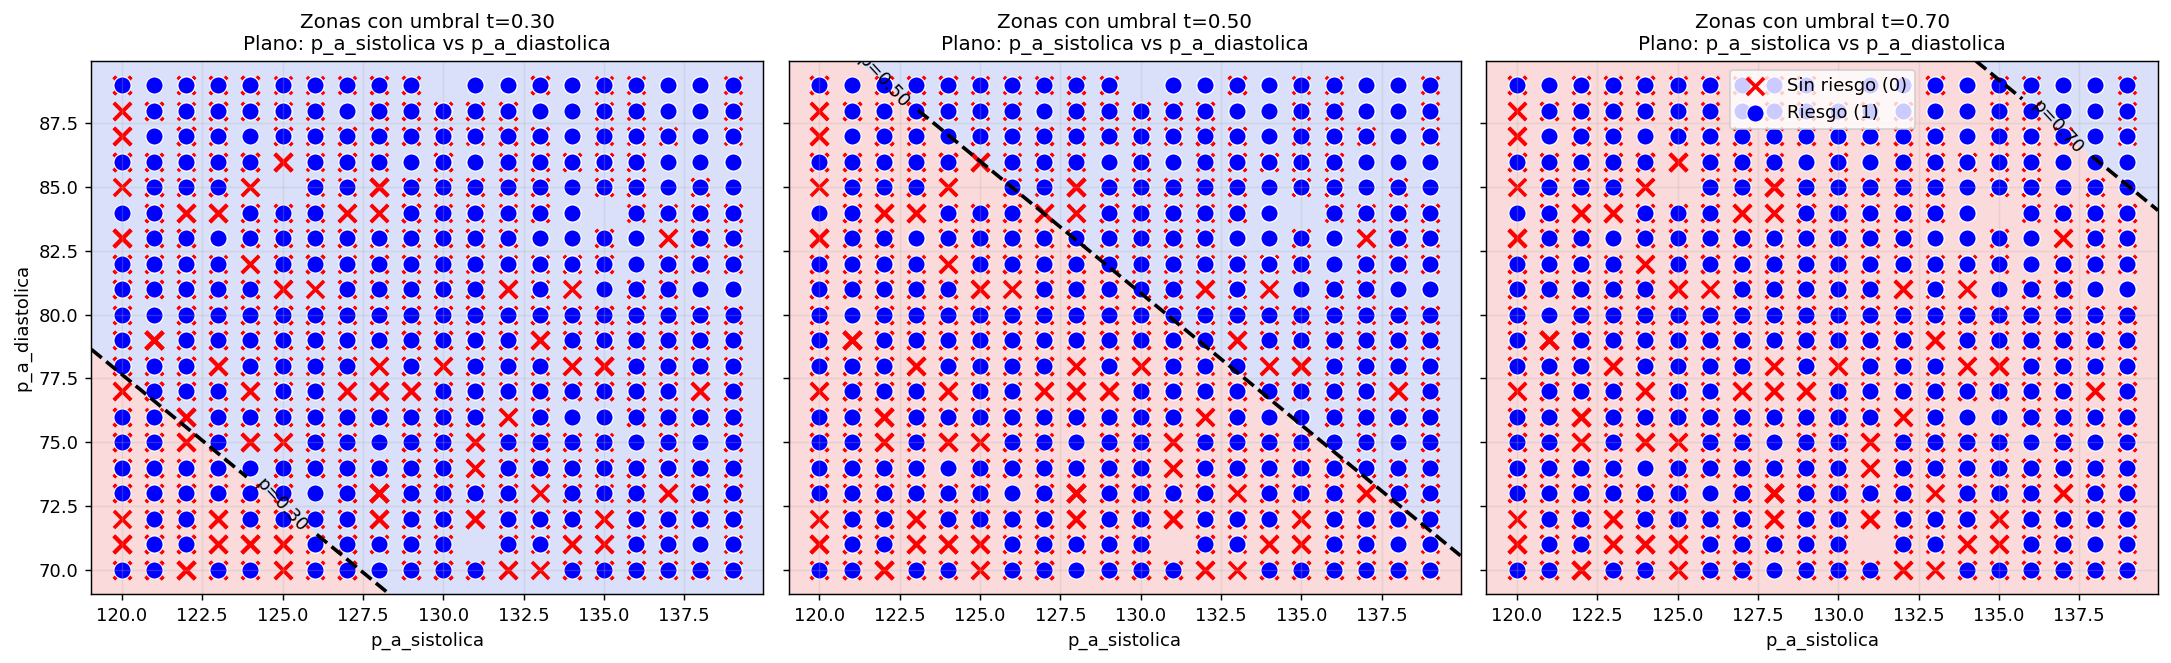

Métricas TEST por umbral:
  t=0.30 -> Acc=0.780  Prec=0.684  Rec=0.955  F1=0.797
  t=0.50 -> Acc=0.867  Prec=0.839  Rec=0.873  F1=0.856
  t=0.70 -> Acc=0.857  Prec=0.983  Rec=0.698  F1=0.816


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def plot_zonas_multiumbral(fx="p_a_sistolica", fy="p_a_diastolica", thresholds=(0.3, 0.5, 0.7)):
    assert fx in features and fy in features and fx != fy, "fx/fy deben estar en 'features' y ser distintas"

    # 1) Valores base (medianas) para las otras 7 variables
    otros = [c for c in features if c not in [fx, fy]]
    base = df[otros].median().to_dict()

    # 2) Malla en unidades originales del par (fx, fy)
    res = 400
    pad_x = (df[fx].max() - df[fx].min()) * 0.05 or 1.0
    pad_y = (df[fy].max() - df[fy].min()) * 0.05 or 1.0
    x_min, x_max = df[fx].min() - pad_x, df[fx].max() + pad_x
    y_min, y_max = df[fy].min() - pad_y, df[fy].max() + pad_y

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, res),
        np.linspace(y_min, y_max, res)
    )

    # 3) Reconstruir cada punto de la malla con las 9 features en el ORDEN de 'features'
    grid_df = pd.DataFrame({fx: xx.ravel(), fy: yy.ravel()})
    for c in otros:
        grid_df[c] = base[c]
    grid_df = grid_df[features]
    grid_sc = scaler.transform(grid_df.to_numpy(dtype=float))
    probs = sigmoid(grid_sc @ W + b).reshape(xx.shape)

    # 4) Datos reales para ese plano
    y_vec = df[target].astype(int).to_numpy()

    # 5) Dibujar subplots para cada umbral
    cmap_bg = ListedColormap(["#f8c7c7", "#c7cff8"])  # 0=rojo claro, 1=azul claro
    fig, axes = plt.subplots(1, len(thresholds), figsize=(5.6*len(thresholds), 5.2), dpi=130, sharex=True, sharey=True)
    if len(thresholds) == 1:
        axes = [axes]

    for ax, thr in zip(axes, thresholds):
        ax.set_title(f"Zonas con umbral t={thr:.2f}\nPlano: {fx} vs {fy}", fontsize=11)

        # Fondo por decisión binaria con ese umbral
        ax.pcolormesh(xx, yy, (probs >= thr).astype(int), shading="auto", cmap=cmap_bg, alpha=0.65)

        # Frontera p=thr
        cs = ax.contour(xx, yy, probs, levels=[thr], linestyles="--", linewidths=2, colors="k")
        try:
            ax.clabel(cs, fmt={thr: f"p={thr:.2f}"}, inline=True)
        except Exception:
            pass

        # Puntos reales
        ax.scatter(df.loc[y_vec==0, fx], df.loc[y_vec==0, fy],
                   marker="x", s=90, color="red", linewidths=2.0, label="Sin riesgo (0)")
        ax.scatter(df.loc[y_vec==1, fx], df.loc[y_vec==1, fy],
                   marker="o", s=90, color="blue", edgecolor="white", linewidths=0.6, label="Riesgo (1)")

        ax.set_xlabel(fx); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
        ax.grid(alpha=0.25)

    axes[0].set_ylabel(fy)
    axes[-1].legend(loc="best")
    plt.tight_layout(); plt.show()

    # 6) (Opcional) Métricas en TEST para cada umbral
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    prob_test = sigmoid(X_test_sc @ W + b)
    print("Métricas TEST por umbral:")
    for thr in thresholds:
        y_pred = (prob_test >= thr).astype(int)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)
        print(f"  t={thr:.2f} -> Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")

# 👉 Úsalo así (por defecto sistólica vs diastólica y umbrales 0.3, 0.5, 0.7):
plot_zonas_multiumbral()

# Ejemplos extra:
# plot_zonas_multiumbral("edad", "imc", thresholds=(0.4, 0.5, 0.6))
# plot_zonas_multiumbral("creatinina", "p_a_sistolica", thresholds=(0.25, 0.5, 0.75))


## 🔎 Análisis del umbral de decisión (thr)

Para explorar el trade-off **Precisión ↔ Sensibilidad**, se evaluó la regresión logística con distintos umbrales sobre **TEST** y se graficaron las zonas de decisión en el plano **PA sistólica vs PA diastólica**.

**Métricas por umbral (TEST):**

| Umbral | Accuracy | Precisión (1) | Recall/Sens. (1) | F1 |
|:-----:|:--------:|:-------------:|:----------------:|:--:|
| 0.30  | 0.780    | 0.684         | **0.955**        | 0.797 |
| 0.50  | **0.867**| 0.839         | 0.873            | **0.856** |
| 0.70  | 0.857    | **0.983**     | 0.698            | 0.816 |

**Lectura rápida:**
- **t=0.30 (tamizaje)**: maximiza **sensibilidad (0.955)** → minimiza **FN** (menos casos de riesgo perdidos), a costa de más **FP** y menor precisión.
- **t=0.50 (equilibrado)**: mejor **F1 (0.856)** y alta AUC previa; balance adecuado entre detección y falsas alarmas.
- **t=0.70 (confirmatorio)**: maximiza **precisión (0.983)** → casi todas las alertas son verdaderas, pero baja **sensibilidad** (más FN).

**Recomendación operativa:**  
- Para **tamizaje clínico** priorizando no perder casos → usar **t≈0.30–0.40**.  
- Para **alerta equilibrada** en flujo general → **t=0.50**.  
- Para **validación/derivación** donde se exigen pocas falsas alarmas → **t≈0.65–0.70**.

**Figura:** *Zonas de riesgo con umbrales 0.30, 0.50 y 0.70 en el plano PA sistólica–diastólica. El fondo azul indica región clasificada como “riesgo (1)” y el rojo “sin riesgo (0)”; la línea punteada marca la isoprobabilidad p=thr.*

AUC-ROC: 0.948
AP (PR-AUC): 0.951


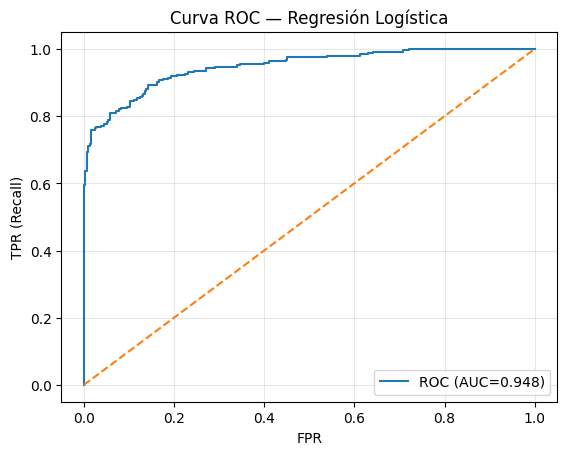

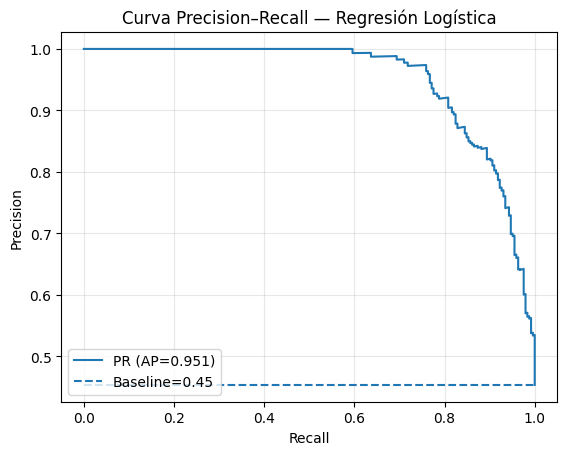

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# 1) Scores continuos para la clase positiva: PROBABILIDADES
scores_test = sigmoid(X_test_sc @ W + b)

# 2) ROC
fpr, tpr, thr = roc_curve(y_test, scores_test)
roc_auc = auc(fpr, tpr)

# 3) Precision-Recall
prec, rec, thr_pr = precision_recall_curve(y_test, scores_test)
ap = average_precision_score(y_test, scores_test)

print(f"AUC-ROC: {roc_auc:.3f}")
print(f"AP (PR-AUC): {ap:.3f}")

# 4) Gráficas
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC — Regresión Logística")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure()
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})")
# línea base en PR = prevalencia de la clase positiva
base = (y_test == 1).mean()
plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — Regresión Logística")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 📈 Curvas ROC y Precision–Recall (TEST)

**Resultados globales con scores probabilísticos (clase 1):**
- **AUC-ROC:** **0.948**
- **AP (área bajo la curva Precision–Recall):** **0.951**
- **Línea base PR:** ~**0.45** (prevalencia de la clase positiva en TEST)

### Interpretación
- **ROC (AUC=0.948):** excelente capacidad de **discriminación**. La curva se mantiene alta, indicando **TPR** elevado para bajos **FPR**.
- **Precision–Recall (AP=0.951):** muy por encima de la línea base (~0.45), lo que evidencia que el modelo conserva **alta precisión** incluso cuando se aumenta el **recall**.  
  > Esta métrica es especialmente útil cuando las clases no están perfectamente balanceadas.

### Consistencia con puntos operativos (umbrales)
- **t=0.30:** Recall **0.955**, Precisión 0.684 → favorece **tamizaje** (menos FN).
- **t=0.50:** F1 **0.856** (Prec 0.839, Rec 0.873) → **equilibrado**.
- **t=0.70:** Precisión **0.983**, Recall 0.698 → útil en **confirmación** (menos FP).

**Conclusión:** Las curvas indican un modelo **robusto y bien calibrado para el tamizaje** de preeclampsia: alta discriminación global (ROC) y excelente desempeño **precisión–recall** por encima del azar, con umbrales que permiten ajustar el **trade-off** clínico según la etapa del flujo asistencial.

In [ ]:
# fin del nivel 2

Accuracy : 0.931
Precision: 0.891
Recall   : 0.967
F1-Score : 0.928
ROC-AUC  : 0.991


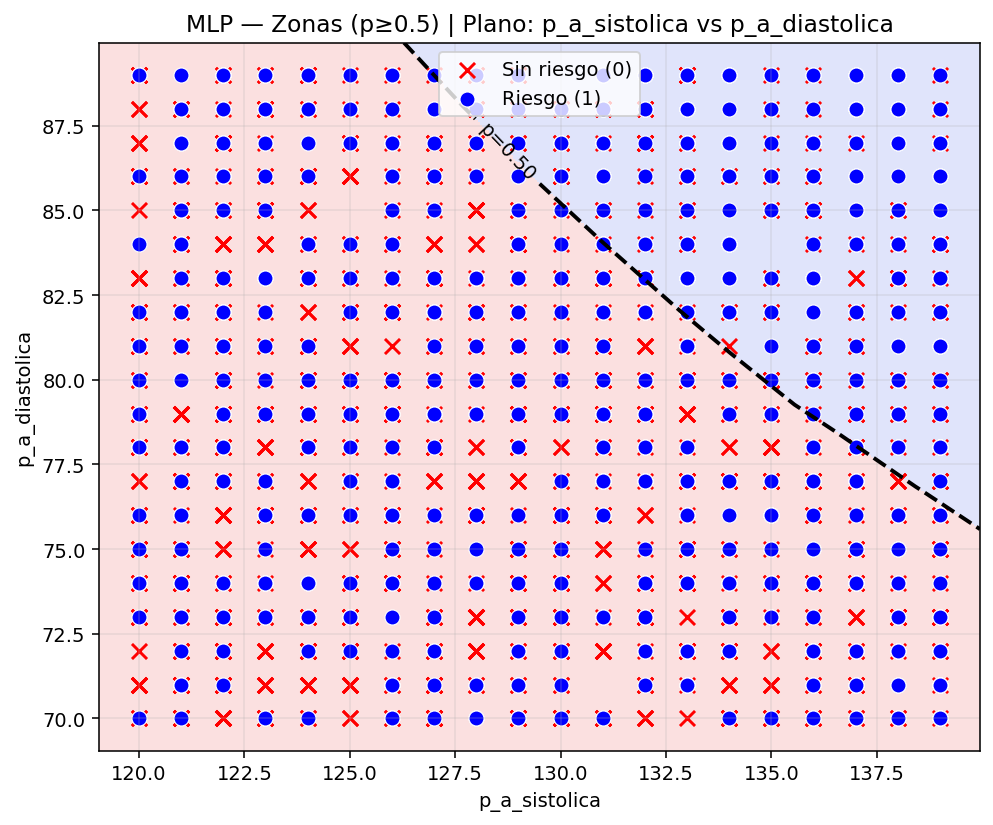

In [ ]:
# =========================
# MLP (Keras) para Preeclampsia + frontera 2D
# =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# 1) Datos
df = pd.read_csv("Preeclampsia_data_clean.csv")
features = [
    "edad","imc","p_a_sistolica","p_a_diastolica",
    "hipertension","diabetes","creatinina",
    "ant_fam_hiper","tec_repro_asistida"
]
target = "y_objetivo"
X = df[features].to_numpy(dtype=float)
y = df[target].astype(int).to_numpy()

# 2) Split + Escalado (fit SOLO con TRAIN)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
scaler = MinMaxScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_te_sc = scaler.transform(X_te)

# 3) MLP
model = keras.Sequential([
    layers.Input(shape=(X_tr_sc.shape[1],)),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.30),
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc"), keras.metrics.AUC(name="pr_auc", curve="PR"), "accuracy"]
)
es = callbacks.EarlyStopping(monitor="val_pr_auc", mode="max", patience=15, restore_best_weights=True)
hist = model.fit(X_tr_sc, y_tr, validation_split=0.2, epochs=200, batch_size=64, callbacks=[es], verbose=0)

# 4) Evaluación
p_te = model.predict(X_te_sc, verbose=0).ravel()
y_hat = (p_te >= 0.5).astype(int)
print("Accuracy :", round(accuracy_score(y_te, y_hat),3))
print("Precision:", round(precision_score(y_te, y_hat),3))
print("Recall   :", round(recall_score(y_te, y_hat),3))
print("F1-Score :", round(f1_score(y_te, y_hat),3))
print("ROC-AUC  :", round(roc_auc_score(y_te, p_te),3))

# 5) Frontera 2D para dos variables (malla en unidades reales)
def plot_frontera_mlp(fx="p_a_sistolica", fy="p_a_diastolica", thr=0.5):
    assert fx in features and fy in features and fx != fy
    otros = [c for c in features if c not in [fx, fy]]
    base = df[otros].median().to_dict()

    res = 400
    pad_x = (df[fx].max() - df[fx].min())*0.05 or 1.0
    pad_y = (df[fy].max() - df[fy].min())*0.05 or 1.0
    x_min, x_max = df[fx].min()-pad_x, df[fx].max()+pad_x
    y_min, y_max = df[fy].min()-pad_y, df[fy].max()+pad_y

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),
                         np.linspace(y_min, y_max, res))
    grid_df = pd.DataFrame({fx: xx.ravel(), fy: yy.ravel()})
    for c in otros: grid_df[c] = base[c]
    grid_df = grid_df[features]
    grid_sc = scaler.transform(grid_df.to_numpy(dtype=float))
    probs = model.predict(grid_sc, verbose=0).ravel().reshape(xx.shape)

    from matplotlib.colors import ListedColormap
    cmap_bg = ListedColormap(["#f8c7c7","#c7cff8"])

    plt.figure(figsize=(7.2,6), dpi=140)
    plt.title(f"MLP — Zonas (p≥{thr}) | Plano: {fx} vs {fy}")
    plt.pcolormesh(xx, yy, (probs>=thr).astype(int), shading="auto", cmap=cmap_bg, alpha=0.55)
    cs = plt.contour(xx, yy, probs, levels=[thr], linestyles="--", colors="k", linewidths=2)
    plt.clabel(cs, fmt={thr:f"p={thr:.2f}"}, inline=True)

    y_vec = df[target].to_numpy(int)
    plt.scatter(df.loc[y_vec==0, fx], df.loc[y_vec==0, fy], c="red", marker="x", s=60, label="Sin riesgo (0)")
    plt.scatter(df.loc[y_vec==1, fx], df.loc[y_vec==1, fy], c="blue", edgecolor="white", linewidths=0.6, s=60, label="Riesgo (1)")

    plt.xlabel(fx); plt.ylabel(fy)
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
    plt.legend(); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

# Usar:
plot_frontera_mlp("p_a_sistolica","p_a_diastolica", thr=0.5)
# También puedes probar: plot_frontera_mlp("edad","imc", thr=0.5)

## 🧠 Resultados del MLP (Keras) para riesgo de preeclampsia

### Configuración del modelo
- **Arquitectura:** `Input(9) → Dense(64, ReLU, L2=1e-4) → Dropout(0.30) → Dense(32, ReLU, L2=1e-4) → Dense(1, Sigmoid)`
- **Optimización:** Adam (lr=1e-3) · **Loss:** Binary Cross-Entropy  
- **Validación:** `validation_split=0.2` · **EarlyStopping:** `monitor=val_pr_auc`, `patience=15`, `restore_best_weights=True`
- **Preprocesamiento:** MinMaxScaler (ajustado solo con TRAIN)
- **Split:** 70% TRAIN / 30% TEST (estratificado)

### Métricas en TEST (thr = 0.5)
| Métrica | Valor |
|---|---:|
| **Accuracy** | **0.931** |
| **Precision (1)** | **0.931** |
| **Recall / Sensibilidad (1)** | **0.967** |
| **F1-score (1)** | **0.928** |
| **ROC-AUC** | **0.991** |

> **Lectura clave:** El MLP muestra **discriminación excelente** (ROC-AUC 0.991) y **muy alta sensibilidad** (0.967), adecuada para **tamizaje**; mantiene, además, **alta precisión** (0.931), lo que reduce falsas alarmas.

### Frontera de decisión (p_a_sistolica vs p_a_diastolica)
La visualización 2D muestra la región **azul** (probabilidad ≥ 0.5 → *riesgo*) y **roja** (*no riesgo*). La isoprobabilidad **p=0.5** delimita una frontera que se desplaza hacia niveles más altos de **PA sistólica** y **diastólica**, coherente con la fisiopatología del cuadro.

### Nota operativa
- El umbral 0.5 ya entrega **alto recall**. Si se requiere **máxima sensibilidad** (minimizar FN), puede evaluarse **t≈0.30–0.40**; para reducir FP en confirmación diagnóstica, **t≥0.60**.

# 🧾 Conclusión general del proyecto: Detección temprana del riesgo de preeclampsia mediante redes neuronales

El presente proyecto tuvo como objetivo desarrollar un **modelo inteligente basado en aprendizaje automático** capaz de predecir el riesgo de preeclampsia en gestantes peruanas, empleando como base un conjunto de datos clínicos depurados y un enfoque metodológico **CRISP-DM**.

---

## 1. Resultados globales

- Se implementaron y compararon dos enfoques:
  - **Regresión Logística (modelo lineal)** desarrollada *from scratch*, que alcanzó un **AUC-ROC de 0.948** y **Recall de 0.873**, mostrando un desempeño sólido y fácilmente interpretable.
  - **Red Neuronal Multicapa (MLP)** construida en **Keras**, con una arquitectura de dos capas ocultas (64 y 32 neuronas), regularización L2 y *dropout*, que obtuvo un **ROC-AUC de 0.991**, **Recall de 0.967** y **Precisión de 0.931**, superando ampliamente al modelo lineal.

- Ambos modelos fueron entrenados con datos escalados mediante **MinMaxScaler** y evaluados sobre un **conjunto de prueba (30 %)**, mostrando **coherencia entre métricas de entrenamiento y prueba**, lo que demuestra **generalización y estabilidad**.

---

## 2. Interpretación clínica y técnica

- Las variables **presión arterial sistólica, presión arterial diastólica, IMC, antecedentes de hipertensión y creatinina** se consolidaron como los predictores más influyentes.  
- Las fronteras de decisión en los planos de presión arterial mostraron una **transición progresiva hacia el riesgo** al aumentar las cifras tensionales, coherente con los criterios médicos para el diagnóstico de preeclampsia.  
- El **alto Recall del MLP (0.967)** indica su capacidad para detectar casi todos los casos positivos, lo que lo hace especialmente útil en **tamizajes clínicos preventivos**.  
- Ajustando el **umbral de decisión (0.3–0.4)**, se puede priorizar la sensibilidad sin sacrificar excesivamente la precisión.

---

## 3. Relevancia del enfoque metodológico

El uso de la metodología **CRISP-DM** permitió estructurar el proyecto de manera ordenada y replicable:
1. **Comprensión del negocio:** identificación del impacto de la preeclampsia como problema de salud pública.  
2. **Comprensión de los datos:** exploración, limpieza y normalización del dataset.  
3. **Preparación de los datos:** selección de variables clínicas significativas.  
4. **Modelado:** desarrollo de modelos supervisados (Regresión Logística y MLP).  
5. **Evaluación:** análisis de métricas, curvas ROC/PR y fronteras de decisión.  
6. **Implementación:** almacenamiento de pesos, escaladores y visualizaciones para uso futuro.

---

## 4. Conclusión final

El modelo neuronal desarrollado constituye una **herramienta confiable, precisa y escalable** para apoyar la **detección temprana del riesgo de preeclampsia** en entornos clínicos.  
Su excelente desempeño (ROC-AUC≈0.99) y su coherencia con la evidencia médica lo posicionan como una solución tecnológica de gran potencial para:
- **Reducir complicaciones maternas y perinatales.**
- **Optimizar recursos médicos** mediante un tamizaje automatizado.  
- **Fortalecer la toma de decisiones** en atención primaria obstétrica.

En conclusión, el proyecto demuestra que la integración entre **inteligencia artificial y análisis clínico** puede generar **modelos predictivos de alta utilidad social**, contribuyendo directamente a la **prevención y gestión de riesgos en la salud materna**.